In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import functools
import operator

In [2]:
weather_data = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_1_Generation_Data.csv')

In [3]:
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])

In [4]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,136,15,00:15:00,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,136,30,00:30:00,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,136,45,00:45:00,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,136,60,01:00:00,1


In [5]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
merged_df

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68769,2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23
68770,2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23
68771,2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23
68772,2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23


In [6]:
#Removing the outliers to have a better fit of the data
clean_data=merged_df.copy()
for i, j in  clean_data.groupby(clean_data.HOUR):
    outlier_condition1=j['DC_POWER']>=(j['DC_POWER'].mean()+ 3*j['DC_POWER'].std())
    outlier_condition2=j['DC_POWER']<(j['DC_POWER'].mean()- 3*j['DC_POWER'].std())
    clean_data.drop(clean_data.loc[(clean_data['DAY'].isin(j.loc[outlier_condition1|outlier_condition2].DAY))&(clean_data['HOUR']==i)].index, inplace=True)

In [7]:
def Irr_dc_linear_fit(data):
    coeff=[]
    days=[]
    inverters=[]
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            inverters.append(i)
            INV=pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
            days.append(a)
            DAYS=pd.DataFrame(data=np.array(days), columns=['DAY'])
            X = day['IRRADIATION'].values.reshape(-1,1)
            y = day['DC_POWER'].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_
            result = []
            [result.extend(el) for el in m] 
            E=[]
            for el in result:
                E.append(el)
            coeff.append(E)
            coefficients = pd.DataFrame(data=np.array(coeff), columns=['Conversion_coeff'])
            conv = [INV, DAYS, coefficients]
            conversion_data = pd.concat(conv, axis=1)
    return(conversion_data)

In [40]:
def find_cloudiness(data, col_name):
    data['DATE_TIME']= pd.to_datetime(data['DATE_TIME'])
    data['DAY'] = pd.DatetimeIndex(data['DATE_TIME']).dayofyear
    data['TIME'] = data.DATE_TIME.dt.time
    data['HOUR'] = data.DATE_TIME.dt.hour
    agg_h_irr = data.groupby(data.TIME).agg({col_name: 'max'})
    #Removing outliers 
    clean_data=data.copy()
    for i, j in  clean_data.groupby(clean_data.HOUR):
        outlier_condition1=(j[col_name]!=0)&(j[col_name]>=(j[col_name].mean()+ 2*j[col_name].std()))
        outlier_condition2=(j[col_name]!=0)&(j[col_name]<(j[col_name].mean()- 2*j[col_name].std()))
        clean_data.drop(clean_data.loc[(clean_data['DAY'].isin(j.loc[outlier_condition1|outlier_condition2].DAY))&
                                       (clean_data['HOUR']==i)].index, inplace=True)
    agg_h_irr_clean = clean_data.groupby(clean_data.TIME).agg({col_name: 'max'})
    weather_maxirr = pd.merge(data, agg_h_irr_clean, how='inner', on='TIME', suffixes=('', '_max'))
    weather_maxirr['offset_from_max']=(weather_maxirr[col_name+'_max']-weather_maxirr[col_name])**2
    C_day_list=weather_maxirr.groupby('DAY').sum()['offset_from_max']
    weather_maxirr = pd.merge(weather_maxirr, C_day_list, how='inner', on='DAY')
    weather_maxirr_new = weather_maxirr.rename(columns={'offset_from_max_y': 'C_day', 
                                                        'offset_from_max_x': 'offset_from_max'})
    ###sorry ehre returning just day-value array, because it is easier for the plot. we'll figure out eventually what we need to return
    return(C_day_list)

In [66]:
conversion_data=Irr_dc_linear_fit(clean_data)
conversion_data.head()

,SOURCE_KEY,DAY,Conversion_coeff
0,1BY6WEcLGh8j5v7,136,12354.989316
1,1BY6WEcLGh8j5v7,137,13795.526206
2,1BY6WEcLGh8j5v7,138,12442.529876
3,1BY6WEcLGh8j5v7,139,13206.622964
4,1BY6WEcLGh8j5v7,140,12853.514593


In [94]:
C_day=find_cloudiness(weather_data, 'IRRADIATION')
#C_day=pd.DataFrame(C_day)
#C_day.columns=['C_day']
#C_day['DAY']=C_day.index

In [90]:
clean_data = pd.merge(clean_data, conversion_data, how='left', on=['DAY', 'SOURCE_KEY'])

In [91]:
conversion_data_lowT=Irr_dc_linear_fit(clean_data[clean_data['MODULE_TEMPERATURE']<=50])
conversion_data_lowT.head()

,SOURCE_KEY,DAY,Conversion_coeff
0,1BY6WEcLGh8j5v7,136,12924.970538
1,1BY6WEcLGh8j5v7,137,13815.536204
2,1BY6WEcLGh8j5v7,138,12746.229788
3,1BY6WEcLGh8j5v7,139,13327.496551
4,1BY6WEcLGh8j5v7,140,12703.448285


1. derive the inverters if there is any negative trend present
2. derive strong outliers in time, like above

#### AK changed the calculation of the trend to follow a rolling logic

In [153]:
def negative_trend(data, cloudiness, window=10, limit=-0.75):
    """
    Given a dataframe of inverter daily efficiencies calculates negative trends over a window of days. 
    Returns the dataframe with a new column, with 1 where the negative trend is below a certain limit.
    """
    data=data.merge(cloudiness, on='DAY')
    data['efficiency_trend']=0
    data['weather_trend']=0
    data['alarm_negative_trend']=0
    for inv in data.SOURCE_KEY.unique():
        data.loc[data.SOURCE_KEY==inv, 'efficiency_trend']=(data[data.SOURCE_KEY==inv]['DAY']/data[data.SOURCE_KEY==inv]['DAY'].max()).rolling(window=window).corr(data[data.SOURCE_KEY==inv]['Conversion_coeff']/data[data.SOURCE_KEY==inv]['Conversion_coeff'].max())
        data.loc[data.SOURCE_KEY==inv, 'weather_trend']=(data[data.SOURCE_KEY==inv]['Conversion_coeff']/data[data.SOURCE_KEY==inv]['Conversion_coeff'].max()).rolling(window=window).corr(data[data.SOURCE_KEY==inv]['offset_from_max']/data[data.SOURCE_KEY==inv]['offset_from_max'].max())
    data.loc[(data['efficiency_trend']<=limit)&(data['weather_trend']<=0), 'alarm_negative_trend']=1
    ####
    return data.drop(columns=['efficiency_trend', 'weather_trend'])

In [170]:
efficiency_alarms=negative_trend(conversion_data_lowT, C_day, window=10, limit=-0.6)

In [171]:
efficiency_alarms

,SOURCE_KEY,DAY,Conversion_coeff,offset_from_max,alarm_negative_trend
0,1BY6WEcLGh8j5v7,136,12924.970538,5.044330,0
1,1IF53ai7Xc0U56Y,136,13583.565077,5.044330,0
2,3PZuoBAID5Wc2HD,136,13435.806642,5.044330,0
3,7JYdWkrLSPkdwr4,136,13278.527250,5.044330,0
4,McdE0feGgRqW7Ca,136,13719.097506,5.044330,0
...,...,...,...,...,...
743,wCURE6d3bPkepu2,169,14232.372260,6.001389,0
744,z9Y9gH1T5YWrNuG,169,13958.143903,6.001389,0
745,zBIq5rxdHJRwDNY,169,14192.439087,6.001389,0
746,zVJPv84UY57bAof,169,14450.859629,6.001389,0


In [172]:
efficiency_alarms[efficiency_alarms['alarm_negative_trend']==1]

,SOURCE_KEY,DAY,Conversion_coeff,offset_from_max,alarm_negative_trend
402,WRmjgnKYAwPKWDb,154,13676.693828,3.859735,1


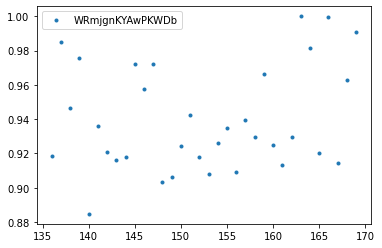

In [175]:
for inv in efficiency_alarms[efficiency_alarms['alarm_negative_trend']==1].SOURCE_KEY.unique():
    plt.plot(efficiency_alarms[efficiency_alarms.SOURCE_KEY==inv]['DAY'], efficiency_alarms[efficiency_alarms.SOURCE_KEY==inv]['Conversion_coeff']/efficiency_alarms[efficiency_alarms.SOURCE_KEY==inv]['Conversion_coeff'].max(), '.', label=inv)
#plt.plot(efficiency_alarms[efficiency_alarms.SOURCE_KEY==inv]['DAY'], efficiency_alarms[efficiency_alarms.SOURCE_KEY==inv]['offset_from_max']/efficiency_alarms[efficiency_alarms.SOURCE_KEY==inv]['offset_from_max'].max(), '.')
plt.legend()

In [141]:
data=conversion_data_lowT
data=data.merge(C_day, on='DAY')
data['efficiency_trend']=0
data['weather_trend']=0
data['alarm_negative_trend']=0
for inv in data.SOURCE_KEY.unique():
    data.loc[data.SOURCE_KEY==inv, 'efficiency_trend']=data[data.SOURCE_KEY==inv]['DAY'].rolling(window=10).corr(data[data.SOURCE_KEY==inv]['Conversion_coeff'])
    data.loc[data.SOURCE_KEY==inv, 'weather_trend']=data[data.SOURCE_KEY==inv]['Conversion_coeff'].rolling(window=10).corr(data[data.SOURCE_KEY==inv]['offset_from_max'])
data.loc[(data['efficiency_trend']<=-0.75)&(data['weather_trend']<=0), 'alarm_negative_trend']=1

In [142]:
data

,SOURCE_KEY,DAY,Conversion_coeff,offset_from_max,efficiency_trend,weather_trend,alarm_negative_trend
0,1BY6WEcLGh8j5v7,136,12924.970538,5.044330,NaN,NaN,0
1,1IF53ai7Xc0U56Y,136,13583.565077,5.044330,NaN,NaN,0
2,3PZuoBAID5Wc2HD,136,13435.806642,5.044330,NaN,NaN,0
3,7JYdWkrLSPkdwr4,136,13278.527250,5.044330,NaN,NaN,0
4,McdE0feGgRqW7Ca,136,13719.097506,5.044330,NaN,NaN,0
...,...,...,...,...,...,...,...
743,wCURE6d3bPkepu2,169,14232.372260,6.001389,0.397255,0.656052,0
744,z9Y9gH1T5YWrNuG,169,13958.143903,6.001389,0.569863,0.796213,0
745,zBIq5rxdHJRwDNY,169,14192.439087,6.001389,0.184362,0.641890,0
746,zVJPv84UY57bAof,169,14450.859629,6.001389,0.124516,0.798959,0


(135.0, 170.0)

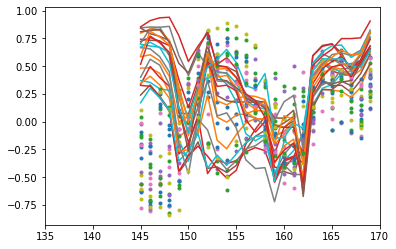

In [145]:
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['efficiency_trend'], '.', label=inv)
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['weather_trend'])
plt.xlim(135, 170)

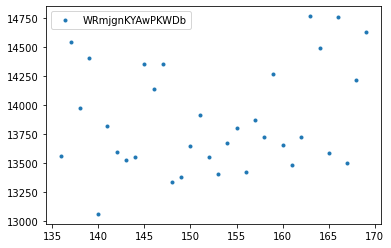

In [147]:
for inv in data[(data['efficiency_trend']<=-0.60)&(data['weather_trend']<=0)].SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['Conversion_coeff'], '.', label=inv)
plt.legend()

In [148]:
data[(data['efficiency_trend']<=-0.60)&(data['weather_trend']<=0)]

,SOURCE_KEY,DAY,Conversion_coeff,offset_from_max,efficiency_trend,weather_trend,alarm_negative_trend
402,WRmjgnKYAwPKWDb,154,13676.693828,3.859735,-0.619417,-0.509848,0


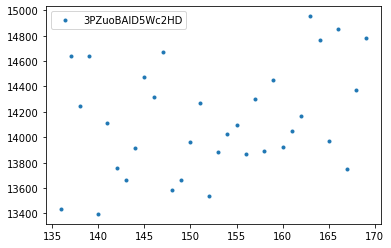

In [84]:
for inv in data[(data['efficiency_trend']>=0.5)&(data['weather_trend']<=-0.5)].SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['Conversion_coeff'], '.', label=inv)
plt.legend()

In [34]:
print(data[data['efficiency_trend']<=-0.8].SOURCE_KEY.unique(), data[data['efficiency_trend']>=0.8].SOURCE_KEY.unique())

['ZoEaEvLYb1n2sOq' 'uHbuxQJl8lW7ozc' 'zBIq5rxdHJRwDNY'] ['McdE0feGgRqW7Ca' 'iCRJl6heRkivqQ3' 'rGa61gmuvPhdLxV' 'zBIq5rxdHJRwDNY']


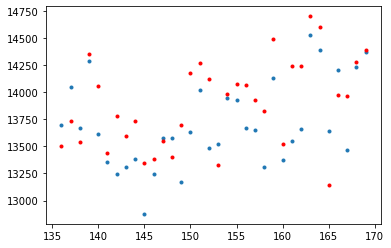

In [39]:
inv="ZoEaEvLYb1n2sOq"
plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['Conversion_coeff'], '.', label=inv)
inv="pkci93gMrogZuBj"
plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['Conversion_coeff'], 'r.', label=inv)

In [35]:
data[(data['efficiency_trend']>=-0.5)&(data['efficiency_trend']<=0.5)].SOURCE_KEY.unique()

array(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
       '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
       'WRmjgnKYAwPKWDb', 'ZnxXDlPa8U1GXgE', 'ZoEaEvLYb1n2sOq',
       'adLQvlD726eNBSB', 'bvBOhCH3iADSZry', 'iCRJl6heRkivqQ3',
       'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj', 'rGa61gmuvPhdLxV',
       'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc', 'wCURE6d3bPkepu2',
       'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY', 'zVJPv84UY57bAof',
       'YxYtjZvoooNbGkE'], dtype=object)

In [11]:
def negative_trend(data):
    data['neg_trend']=0
    for inv in data.SOURCE_KEY.unique():
        if data[data.SOURCE_KEY==inv][['DAY', 'Conversion_coeff']].corr()['Conversion_coeff']['DAY']<=0:
            data.neg_trend[(data.SOURCE_KEY==inv)& (data.DAY==169)]=1
    return(data)

In [12]:
neg=negative_trend(conversion_data_lowT)

In [13]:
neg[neg.neg_trend==1]

,SOURCE_KEY,DAY,Conversion_coeff,neg_trend


#### AK changed slightly the format of the strong outlier detection function

In [223]:
def strong_outliers(data, outlier_coeff, window=20):
    """
    Given a dataframe of inverter daily efficiencies calculates efficiency jumps and falls relative to inverter history.
    """
    data['alarm_efficiency_fall']=0
    data['alarm_efficiency_jump']=0
    data['efficiency_lower_limit']=0
    data['efficiency_higher_limit']=0
    if window:
        for inv in data.SOURCE_KEY.unique():
            data.loc[data.SOURCE_KEY==inv, 'efficiency_lower_limit']=data[data.SOURCE_KEY==inv]['Conversion_coeff'].rolling(window=window).mean()-outlier_coeff*data[data.SOURCE_KEY==inv]['Conversion_coeff'].rolling(window=window).std()
            data.loc[data.SOURCE_KEY==inv, 'efficiency_higher_limit']=data[data.SOURCE_KEY==inv]['Conversion_coeff'].rolling(window=window).mean()+outlier_coeff*data[data.SOURCE_KEY==inv]['Conversion_coeff'].rolling(window=window).std()
    else:
        for inv in data.SOURCE_KEY.unique():
            data.loc[data.SOURCE_KEY==inv, 'efficiency_lower_limit']=data[data.SOURCE_KEY==inv]['Conversion_coeff'].mean()-outlier_coeff*data[data.SOURCE_KEY==inv]['Conversion_coeff'].std()
            data.loc[data.SOURCE_KEY==inv, 'efficiency_higher_limit']=data[data.SOURCE_KEY==inv]['Conversion_coeff'].mean()+outlier_coeff*data[data.SOURCE_KEY==inv]['Conversion_coeff'].std()

    data.loc[data['Conversion_coeff']>data['efficiency_higher_limit'], 'alarm_efficiency_jump']=1
    data.loc[data['Conversion_coeff']<data['efficiency_lower_limit'], 'alarm_efficiency_fall']=1
    return data.drop(columns=['efficiency_lower_limit', 'efficiency_higher_limit'])

In [226]:
final_data=strong_outliers(conversion_data_lowT, 3, window=False)

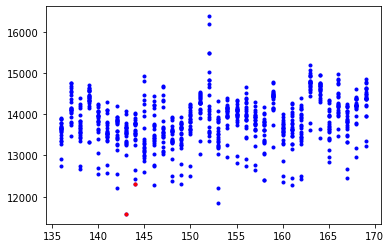

In [227]:
data=final_data
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['Conversion_coeff'], 'b.')
plt.plot(data[data.alarm_efficiency_fall==1]['DAY'], data[data.alarm_efficiency_fall==1]['Conversion_coeff'], 'r.')
#plt.plot(data[data.alarm_efficiency_jump==1]['DAY'], data[data.alarm_efficiency_jump==1]['Conversion_coeff'], 'r.')